In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles, make_moons
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ComplexLinear, self).__init__()
        self.real = nn.Linear(in_features, out_features)
        self.imag = nn.Linear(in_features, out_features)

    def forward(self, x):
        real_part = self.real(x.real) - self.imag(x.imag)
        imag_part = self.real(x.imag) + self.imag(x.real)
        return torch.complex(real_part, imag_part)


# class ComplexReLU(nn.Module):
#     def forward(self, x):
#         return torch.complex(torch.relu(x.real), torch.relu(x.imag))
class ComplexCardioid(nn.Module):
    def forward(self, x):
        return 0.5 * (1+torch.cos(torch.angle(x)))*x


class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, imag=1):
        super(Model, self).__init__()
        self.imag = imag
        if self.imag:
          self.fc1 = ComplexLinear(input_dim, hidden_dim)
          self.act1 = ComplexCardioid()
          self.fc2 = ComplexLinear(hidden_dim, output_dim)
        else:
          self.fc1 = nn.Linear(input_dim, hidden_dim)
          self.act1 = nn.ReLU()
          self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        if self.imag:
          x = x.abs()
        return x

In [ ]:
# Create a complex-valued dataset
data, labels = make_moons(8_000, noise=0.05)

data = torch.tensor(data).to(torch.float32)

model_complex = Model(input_dim=1, hidden_dim=4, output_dim=1)

inp = torch.complex(real=data[:, 0], imag=data[:, 1])

# Model, loss function, and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_complex.parameters(), lr=0.1)

## Train Complex model Moon dataset

In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model_complex(inp.unsqueeze(1))
    loss = criterion(outputs, torch.tensor(labels).unsqueeze(1).float())
    loss.backward()
    optimizer.step()

    preds = torch.clone(outputs)

    preds[outputs >= 0.5] = 1
    preds[outputs <= 0.5] = 0

    acc = torch.eq(preds, torch.tensor(labels).unsqueeze(1)).sum()/len(labels)

    print(f'Epoch [{epoch + 1}/1000], Loss: {loss.item()}, Acc: {acc}')

Epoch [1/1000], Loss: 0.6731709241867065, Acc: 0.5078750252723694
Epoch [2/1000], Loss: 0.6933318376541138, Acc: 0.5087500214576721
Epoch [3/1000], Loss: 0.6452182531356812, Acc: 0.7682499885559082
Epoch [4/1000], Loss: 0.6001531481742859, Acc: 0.796999990940094
Epoch [5/1000], Loss: 0.6218462586402893, Acc: 0.7783750295639038
Epoch [6/1000], Loss: 0.5978155732154846, Acc: 0.8050000071525574
Epoch [7/1000], Loss: 0.5779679417610168, Acc: 0.8220000267028809
Epoch [8/1000], Loss: 0.585247278213501, Acc: 0.8301249742507935
Epoch [9/1000], Loss: 0.570242166519165, Acc: 0.831125020980835
Epoch [10/1000], Loss: 0.5557779669761658, Acc: 0.8318750262260437
Epoch [11/1000], Loss: 0.5668283700942993, Acc: 0.7991250157356262
Epoch [12/1000], Loss: 0.5707383155822754, Acc: 0.7908750176429749
Epoch [13/1000], Loss: 0.5666458010673523, Acc: 0.796875
Epoch [14/1000], Loss: 0.5656627416610718, Acc: 0.8151249885559082
Epoch [15/1000], Loss: 0.5651113390922546, Acc: 0.831250011920929
Epoch [16/1000], Lo

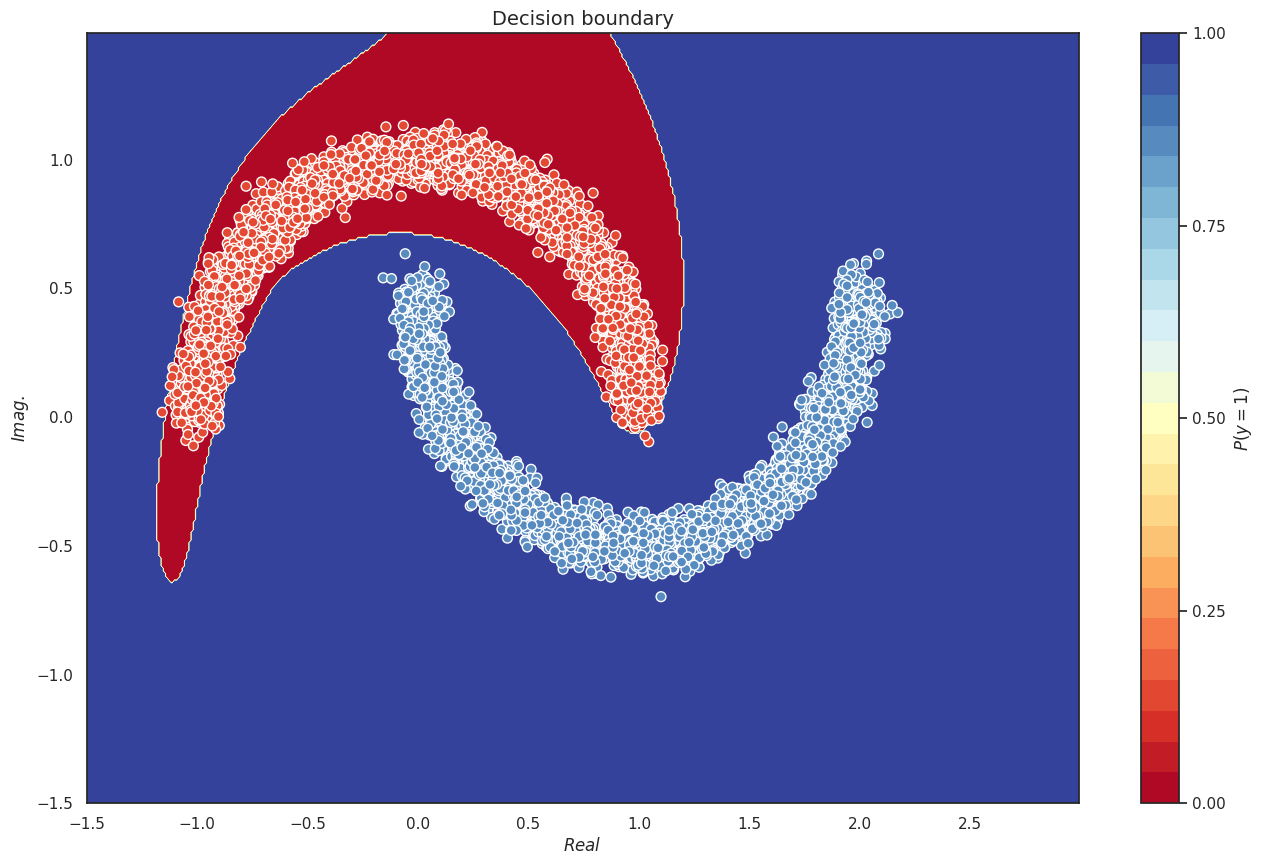

In [ ]:
sns.set(style="white")

# xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
# xx, yy = np.mgrid[-1:1:.001, -1:1:.001]
xx, yy = np.mgrid[-1.5:3.0:.01, -1.5:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)

batch = torch.complex(real=batch[:, 0], imag=batch[:, 1]).unsqueeze(1)

with torch.no_grad():
    # probs = torch.sigmoid(model(batch).reshape(xx.shape))
    probs = model_complex(batch).reshape(xx.shape)
    preds = torch.clone(probs)
    preds[probs >= 0.5] = 1
    preds[probs <= 0.5] = 0
    preds = preds.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, preds, 25, cmap="RdYlBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(data.numpy()[:, 0], data.numpy()[:, 1], c=labels[:], s=50,
           cmap="RdYlBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$Real$", ylabel="$Imag.$")
plt.show()


In [ ]:
# Create a real-valued dataset
data, labels = make_moons(8_000, noise=0.05)

data = torch.tensor(data).to(torch.float32)

model_real = Model(input_dim=2, hidden_dim=4, output_dim=1, imag=0)

# Model, loss function, and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_complex.parameters(), lr=0.1)

## Train Real Model Moon dataset

In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model_real(data)
    loss = criterion(outputs, torch.tensor(labels).unsqueeze(1).float())
    loss.backward()
    optimizer.step()

    preds = torch.clone(outputs)

    preds[outputs >= 0.5] = 1
    preds[outputs <= 0.5] = 0

    acc = torch.eq(preds, torch.tensor(labels).unsqueeze(1)).sum()/len(labels)

    print(f'Epoch [{epoch + 1}/1000], Loss: {loss.item()}, Acc: {acc}')

Epoch [1/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [2/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [3/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [4/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [5/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [6/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [7/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [8/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [9/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [10/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [11/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [12/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [13/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [14/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoch [15/1000], Loss: 0.6430383324623108, Acc: 0.5326250195503235
Epoc

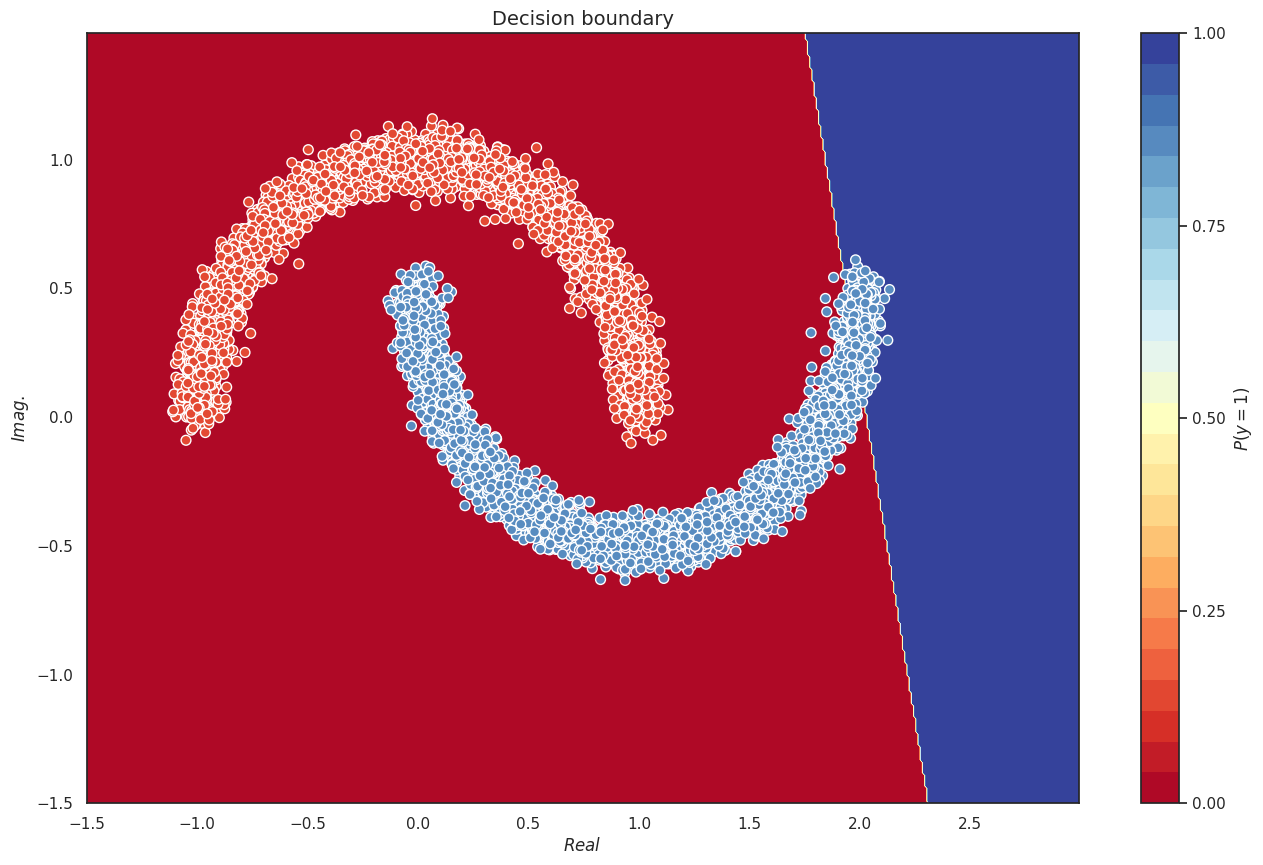

In [ ]:
sns.set(style="white")

# xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
# xx, yy = np.mgrid[-1:1:.001, -1:1:.001]
xx, yy = np.mgrid[-1.5:3.0:.01, -1.5:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)

with torch.no_grad():
    # probs = torch.sigmoid(model(batch).reshape(xx.shape))
    probs = model_real(batch).reshape(xx.shape)
    preds = torch.clone(probs)
    preds[probs >= 0.5] = 1
    preds[probs <= 0.5] = 0
    preds = preds.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, preds, 25, cmap="RdYlBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(data.numpy()[:, 0], data.numpy()[:, 1], c=labels[:], s=50,
           cmap="RdYlBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$Real$", ylabel="$Imag.$")
plt.show()


## Train Complex model Circle dataset

In [ ]:
# Create a complex-valued dataset
data, labels = make_circles(8_000, noise=0.05)

data = torch.tensor(data).to(torch.float32)

model_complex = Model(input_dim=1, hidden_dim=4, output_dim=1)

inp = torch.complex(real=data[:, 0], imag=data[:, 1])

# Model, loss function, and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_complex.parameters(), lr=0.1)

In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model_complex(inp.unsqueeze(1))
    loss = criterion(outputs, torch.tensor(labels).unsqueeze(1).float())
    loss.backward()
    optimizer.step()

    preds = torch.clone(outputs)

    preds[outputs >= 0.5] = 1
    preds[outputs <= 0.5] = 0

    acc = torch.eq(preds, torch.tensor(labels).unsqueeze(1)).sum()/len(labels)

    print(f'Epoch [{epoch + 1}/1000], Loss: {loss.item()}, Acc: {acc}')

Epoch [1/1000], Loss: 0.8492498397827148, Acc: 0.5
Epoch [2/1000], Loss: 0.7416000962257385, Acc: 0.49125000834465027
Epoch [3/1000], Loss: 0.7048730850219727, Acc: 0.5
Epoch [4/1000], Loss: 0.7159620523452759, Acc: 0.4181250035762787
Epoch [5/1000], Loss: 0.7187486290931702, Acc: 0.4672499895095825
Epoch [6/1000], Loss: 0.7122394442558289, Acc: 0.43162500858306885
Epoch [7/1000], Loss: 0.7026208639144897, Acc: 0.5
Epoch [8/1000], Loss: 0.7012986540794373, Acc: 0.5
Epoch [9/1000], Loss: 0.7006772756576538, Acc: 0.5
Epoch [10/1000], Loss: 0.7008434534072876, Acc: 0.47725000977516174
Epoch [11/1000], Loss: 0.7012160420417786, Acc: 0.48225000500679016
Epoch [12/1000], Loss: 0.6985253095626831, Acc: 0.5
Epoch [13/1000], Loss: 0.6949583888053894, Acc: 0.5
Epoch [14/1000], Loss: 0.6936085224151611, Acc: 0.5
Epoch [15/1000], Loss: 0.6961213946342468, Acc: 0.5
Epoch [16/1000], Loss: 0.6940054297447205, Acc: 0.5
Epoch [17/1000], Loss: 0.693378746509552, Acc: 0.5
Epoch [18/1000], Loss: 0.6937120

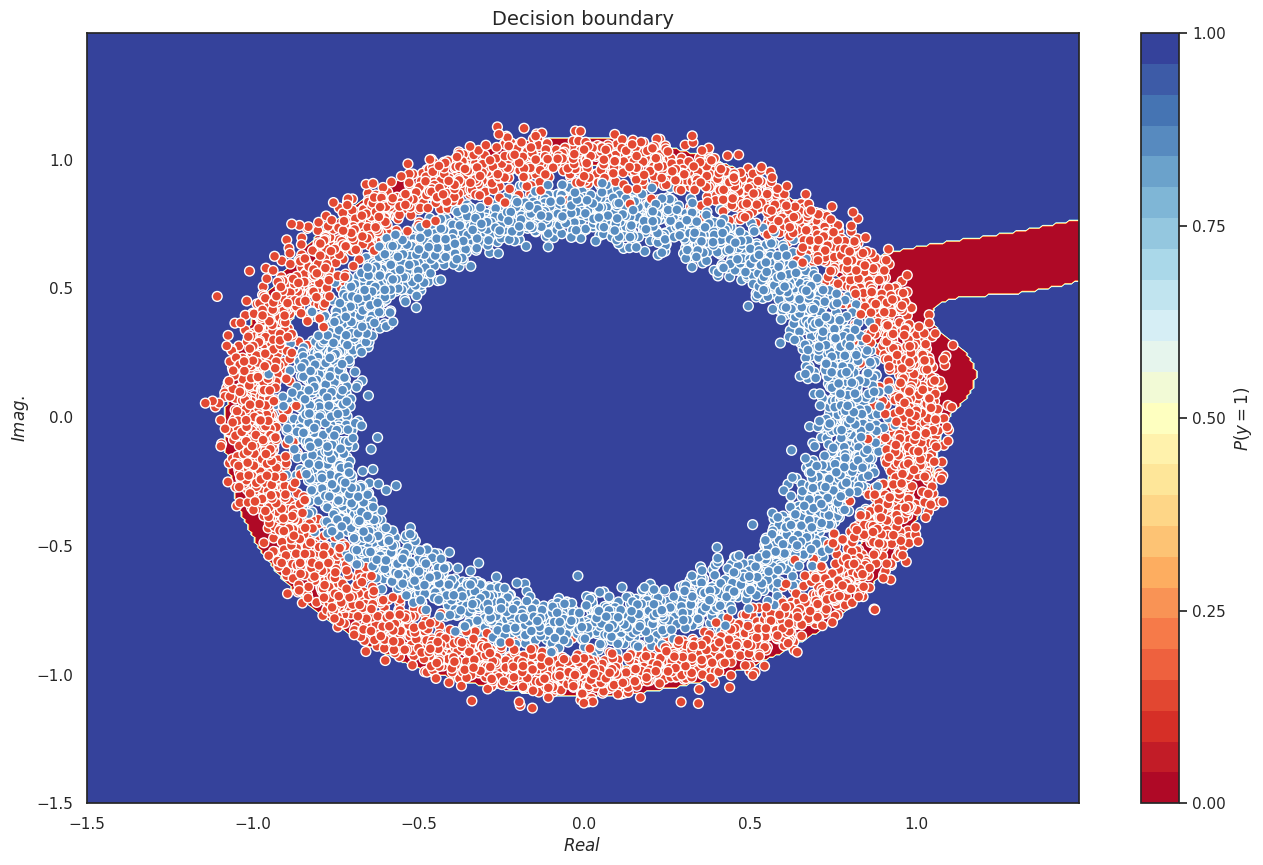

In [ ]:
sns.set(style="white")

# xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
# xx, yy = np.mgrid[-1:1:.001, -1:1:.001]
xx, yy = np.mgrid[-1.5:1.5:.01, -1.5:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)

batch = torch.complex(real=batch[:, 0], imag=batch[:, 1]).unsqueeze(1)

with torch.no_grad():
    # probs = torch.sigmoid(model(batch).reshape(xx.shape))
    probs = model_complex(batch).reshape(xx.shape)
    preds = torch.clone(probs)
    preds[probs >= 0.5] = 1
    preds[probs <= 0.5] = 0
    preds = preds.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, preds, 25, cmap="RdYlBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(data.numpy()[:, 0], data.numpy()[:, 1], c=labels[:], s=50,
           cmap="RdYlBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$Real$", ylabel="$Imag.$")
plt.show()


## Train Real model for circles dataset

In [ ]:
# Create a complex-valued dataset
data, labels = make_circles(8_000, noise=0.05)

data = torch.tensor(data).to(torch.float32)

model_real = Model(input_dim=2, hidden_dim=4, output_dim=1, imag=0)

# Model, loss function, and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_complex.parameters(), lr=0.1)

In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model_real(data)
    loss = criterion(outputs, torch.tensor(labels).unsqueeze(1).float())
    loss.backward()
    optimizer.step()

    preds = torch.clone(outputs)

    preds[outputs >= 0.5] = 1
    preds[outputs <= 0.5] = 0

    acc = torch.eq(preds, torch.tensor(labels).unsqueeze(1)).sum()/len(labels)

    print(f'Epoch [{epoch + 1}/1000], Loss: {loss.item()}, Acc: {acc}')

Epoch [1/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [2/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [3/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [4/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [5/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [6/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [7/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [8/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [9/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [10/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [11/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [12/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [13/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [14/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [15/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [16/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [17/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [18/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [19/1000], Loss: 0.6905899047851562, Acc: 0.5
Epoch [20/1000], Loss

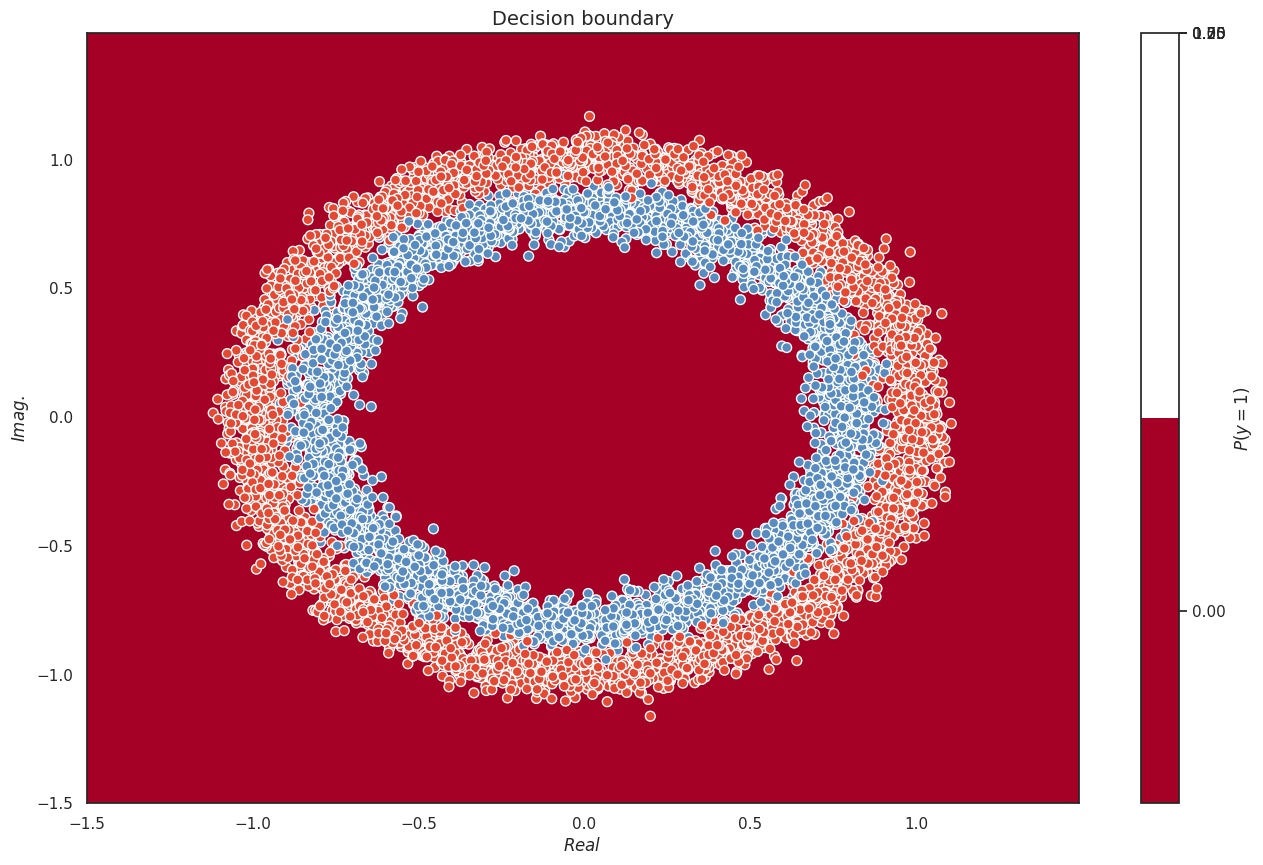

In [ ]:
sns.set(style="white")

# xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
# xx, yy = np.mgrid[-1:1:.001, -1:1:.001]
xx, yy = np.mgrid[-1.5:1.5:.01, -1.5:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)

with torch.no_grad():
    # probs = torch.sigmoid(model(batch).reshape(xx.shape))
    probs = model_real(batch).reshape(xx.shape)
    preds = torch.clone(probs)
    preds[probs >= 0.5] = 1
    preds[probs <= 0.5] = 0
    preds = preds.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, preds, 25, cmap="RdYlBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(data.numpy()[:, 0], data.numpy()[:, 1], c=labels[:], s=50,
           cmap="RdYlBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$Real$", ylabel="$Imag.$")
plt.show()
